# RT-AL applied to the QMOF dataset

**Import requirements and Regresion_Tree**

In [7]:
import os
import warnings
warnings.filterwarnings('ignore')
import scipy
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from regression_tree import Regression_Tree

**Initialise hyperparameters and settings**

In [11]:
# Settings

''' Number of runs for different train-test splits '''
runs = 10   

''' Initial set of samples, labeled randomly '''
label_init = 20     

''' List of total training set sizes to be sampled iteratively '''
training_size = [40,60,80,100,120,140,160,180,200,300,400,500,1000]  

''' List of sample sizes to be labeled at each iteration using RT-AL '''
sample_size = [training_size[0]-label_init]     
for i in range(1,len(training_size)):
    sample_size = np.append(sample_size,training_size[i]-training_size[i-1])  
    
''' List to store Mean Absolute Error (MAE) computed on the test set for each training set size and each run '''
mae_rt_al_test=np.zeros((len(training_size)+1,runs))  

''' Minimum samples in each leaf of the random forest '''
min_samples_leaf_rt_al = 5 

''' Minimum samples in each leaf of the random forest '''
min_samples_leaf_rf = 3  

treeseed = None

descriptors = pd.read_csv('stoich120_fingerprints.csv')

''' Descriptor vector for each MOF, with the 1st element in the list being the name/refcode of the MOF '''
X = descriptors.iloc[:,:].to_numpy() 

''' Length of individual feature vectors for each MOF '''
feat = len(X[0])-1  

print("Length of feature-vector: ",feat)

labels_path = os.path.join('','labels.csv') 

Y = pd.read_csv(labels_path, index_col=0)['BG_PBE'].values

true_y_test = []

pred_rt_test=[]

MOFs_selected_rt=[]

MOF_rt_al = []

Length of feature-vector:  120


**Run RT-AL for different train-test splits**

In [14]:
''' For different train-test splits '''
for run in range(runs):

    print('\n Train-test split: ',run)

    X_train, X_test2, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,random_state=run)
   
    ''' Saving true labels of the test set for each run '''
    true_y_test = np.append(true_y_test,Y_test)
    true_y_test = np.hsplit(true_y_test,len(true_y_test)/len(Y_test)) 
    np.savetxt("Y_test.csv", true_y_test, delimiter=",")
    
    ''' Descriptor vectors of training pool and test set without the MOF names/ refcodes '''
    X_train_init = X_train[:,1:]
    X_test = X_test2[:,1:]

    treeseed = 0
    
    ''' Initial training set, constructed using random sampling, to be updated using RT-AL '''
    X_train_al = X_train_init[:label_init]
    Y_train_al = Y_train[:label_init]
    print('Initial training set size: ', len(X_train_al))

    ''' Set-up the class Regression_Tree for Active Learning '''
    RT = Regression_Tree(seed=treeseed,min_samples_leaf = min_samples_leaf_rt_al)
    
    ''' Input all samples (X_train_init), indices of the labeled MOFs (range(label_init) here) and labels of this set of MOFs (Y_train[:label_init]) '''
    RT.input_data(X_train_init, range(label_init), Y_train[:label_init])
    
    ''' Fit the initial regression tree '''
    RT.fit_tree()
    
    ''' Train the final model (a random forest with 50 trees is used in this work) for this intial set of samples '''
    rf = RandomForestRegressor(min_samples_leaf = min_samples_leaf_rf,n_estimators=50)
    rf.fit(X_train_init[0:label_init], Y_train[:label_init])
    
    ''' Save the names (refcodes) of the MOFs in the training set, into the variable MOF_rt_al '''
    for p in range(label_init):
            MOF_rt_al = np.append(MOF_rt_al,X_train[p][0])
            
    ''' Make predictions using rf on the held-out test set, to keep track of the performace of RT-AL) '''
    Y_test_pred_rn = rf.predict(X_test)
    pred_rt_test = np.append(pred_rt_test,Y_test_pred_rn)
    
    ''' Compute the MAE on the test set '''
    mae_rt_al_test[0][run] = mean_absolute_error(Y_test, Y_test_pred_rn)
 
    ''' Active learning cycle: '''
    for i,j in enumerate(training_size):
        
        ''' Compute the proportion of unlabeled MOFs and variance of true labels of MOFs in each leaf '''
        RT.al_calculate_leaf_proportions()
        
        ''' Select the new MOFs from each leaf based on the sample size'''
        new_points = RT.pick_new_points(num_samples = sample_size[i])
        
        ''' Label the newly selected MOFs '''
        for new_point in new_points:
            RT.label_point(new_point, Y_train[new_point])

        ''' Add the newly selected MOFs to the training set '''
        for k in new_points:
            Y_train_al = np.append(Y_train_al,Y_train[k])
            X_train_al = np.append(X_train_al,X_train_init[k])
            MOF_rt_al = np.append(MOF_rt_al,X_train[k][0])
        X_train_al = np.hsplit(X_train_al,len(X_train_al)/int(feat))
                
        print('Updated training set size: ',len(X_train_al))
        
        ''' Train the rf using the updated training set, and compute MAE on the held-out test set '''
        rf = RandomForestRegressor(min_samples_leaf = min_samples_leaf_rf,n_estimators=50)
        rf.fit(X_train_al, Y_train_al)
        Y_test_pred = rf.predict(X_test)
        pred_rt_test = np.append(pred_rt_test,Y_test_pred)
        pred_rt_test = np.hsplit(pred_rt_test,len(pred_rt_test)/len(Y_test))
        mae_rt_al_test[i+1][run] = mean_absolute_error(Y_test, Y_test_pred)

        ''' Fit the regression tree with the updated training set to continue the cycle '''
        RT.fit_tree()
    
    ''' Save the predicted values '''
    np.savetxt("RT-AL_rf_test_predictions.csv", pred_rt_test, delimiter=",")
    
    ''' Save the MAE values '''
    np.savetxt("RT-AL_rf_test_MAE.csv", mae_rt_al_test, delimiter=",")
    
    ''' Save the list of MOFs selected in the training set '''
    MOFs_selected_rt = MOF_rt_al
    MOFs_selected_rt = np.hsplit(MOFs_selected_rt,len(MOFs_selected_rt)/int(run+1))
    np.savetxt("RT-AL_selected_MOFs.csv", MOFs_selected_rt, fmt="%s",delimiter=",")
        



 Train-test split:  0
Initial training set size:  20
Updated training set size:  40
Updated training set size:  60
Updated training set size:  80
Updated training set size:  100
Updated training set size:  120
Updated training set size:  140
Updated training set size:  160
Updated training set size:  180
Updated training set size:  200
Updated training set size:  300
Updated training set size:  400
Updated training set size:  500
Updated training set size:  1000

 Train-test split:  1
Initial training set size:  20
Updated training set size:  40
Updated training set size:  60
Updated training set size:  80
Updated training set size:  100
Updated training set size:  120
Updated training set size:  140
Updated training set size:  160
Updated training set size:  180
Updated training set size:  200
Updated training set size:  300
Updated training set size:  400
Updated training set size:  500
Updated training set size:  1000

 Train-test split:  2
Initial training set size:  20
Updated tr

**Plot the average MAE cruves for the 10 runs**

Text(17, 0.475, ' 20      40         100     200       500     1000')

<Figure size 432x288 with 0 Axes>

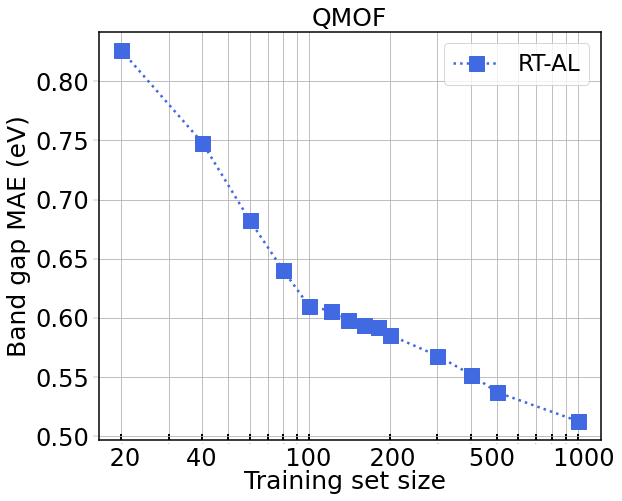

In [33]:
import csv
import matplotlib
import matplotlib.pyplot as plt

maxlabel2=[20,40,60,80,100,120,140,160,180,200,300,400,500,1000]
mae_rt_al = []

with open("RT-AL_rf_test_MAE.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        mae_rt_al.append(np.mean(row))

fm = plt.figure()
fm, axs = plt.subplots()
fm.set_figwidth(9)
fm.set_figheight(7.5)
l=2.5
a=0.4
s=14

axs.plot(maxlabel2,mae_rt_al,c='royalblue',linewidth=l,linestyle = 'dotted',label='RT-AL',marker='s',markersize=15,alpha=1)

axs.legend(loc='upper right', prop={'size': 23})
axs.set_xlabel('Training set size',size=25)
axs.xaxis.set_label_coords(0.49,-0.074)
axs.set_ylabel('Band gap MAE (eV)',size=25)
plt.title('QMOF',size=25)
axs.set_xscale('log') 
plt.grid()
axs.set_xticks([20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
axs.tick_params(axis='x', labelsize=0, length = 6,width=2,direction="in")
axs.tick_params(axis='y', labelsize=24, length = 6,width=0.2,direction="out")

axs.tick_params(axis='x', which='minor')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.text(17, 0.475, ' 20      40         100     200       500     1000', fontsize = 24)